#### Notes pour l'analyse descriptive
Les questions d'analyses descriptives que l'on peut se poser:
- Fréquence des accidents: Où se produisent le plus d'accidents ? À quelles heures ?  Quels mois de l'année ?
- Profils des victimes : Quel est l'âge moyen des victimes ? Quel est leur sexe ? Quelle est leur catégorie sociale ?
- Caractéristiques des véhicules impliqués : Quel type de véhicule est le plus souvent impliqué ? Quel est l'âge moyen des véhicules ?
- Conditions météorologiques : Quel est l'impact de la pluie, du brouillard, de la neige sur la fréquence et la gravité des accidents ?
- Quel type de route est le plus dangereux ? Quelle est l'influence de la présence de virages, de passages piétons, etc. ?

Utilisation possible des résultats:
Amélioration de la sécurité routière : Identification des zones à risque, mise en place de mesures de prévention ciblées
- Identification des zones noires : Les zones où les accidents sont fréquents peuvent être traitées en priorité pour améliorer la sécurité.
- Optimisation des patrouilles de police : Les forces de l'ordre peuvent concentrer leurs efforts sur les zones et les moments où le risque d'accident est le plus élevé.
- Facteurs influençant la gravité: En analysant les données sur les blessures et les décès, on peut identifier les facteurs qui aggravent les conséquences des accidents (vitesse, port de la ceinture de sécurité, type de véhicule).
- Prévision de la gravité d'un accident: En combinant différentes variables, on peut développer des modèles prédictifs pour estimer la gravité potentielle d'un accident en fonction des circonstances.

## Projet python pour la data science / 2024-2025

* Kevin, Oscar, Lisa

## Introduction

In [4]:
!pip install requests
!pip install os
!pip install matplotlib 
!pip install pandas
!pip install plotly
!pip install io
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement io (from versions: none)
ERROR: No matching distribution found for io
Defaulting to user installation because normal site-packages is not writeable


### Importing packages

In [5]:
import requests
import os
import matplotlib.pyplot as plt
import pandas as pd
import plotly
import plotly.express as px
import io
import seaborn as sns

### **I- Présentation des bases de données**

Dans cette partie, nous allons présenté les bases données qui seront utilisées dans ce projet. Il s'agira de faire de brèves descriptions des bases afin de prendre connaissance de leur contenu:
- base des usagers ayant été impliqué dans un accident de circulation en 2023
- base qui donne la description des véhicules impliqués dans un accident de circulation en 2023
- base des lieux où s'est produit l'accident
- base contenant les caractéristiques des accidents.
- base des départements de France
- base des communes de France

In [6]:
# fonction de téléchargement des données sur les accidents corporels
def telecharge(url_data,filename, path):
    # Vérifie si le dossier 'data' existe, sinon le crée
    if not os.path.exists(path):
        os.makedirs(path)
    #télécharge les données avec l'url
    response = requests.get(url_data)
    if response.status_code == 200:
        file_path = os.path.join(path, filename)
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print(f"Fichier {filename} téléchargé avec succès:{file_path}")
    else:
        print(f"Echec de téléchargement pour {filename}. Statut: {response.status_code}")

# API pour accéder à l'url de téléchargement
url_root="https://www.data.gouv.fr/api/1/datasets/53698f4ca3a729239d2036df/resources/"
urls={
    "usagers-2023.csv":"68848e2a-28dd-4efc-9d5f-d512f7dbe66f",
    "vehicules-2023.csv":"146a42f5-19f0-4b3e-a887-5cd8fbef057b",
    "lieux-2023.csv":"8bef19bf-a5e4-46b3-b5f9-a145da4686bc",
    "caract-2023.csv":"104dbb32-704f-4e99-a71e-43563cb604f2"
}
path='/home/onyxia/Projet-Python-pour-la-Data-Science/data'

for filename, resource_id in urls.items():
    url=url_root+resource_id
    response1=requests.get(url)
    if response1.status_code==200:
        data=response1.json()
        url_data=data['url']
    else:
        print("downloading failed")
    telecharge(url_data,filename,path)


Fichier usagers-2023.csv téléchargé avec succès:/home/onyxia/Projet-Python-pour-la-Data-Science/data/usagers-2023.csv
Fichier vehicules-2023.csv téléchargé avec succès:/home/onyxia/Projet-Python-pour-la-Data-Science/data/vehicules-2023.csv
Fichier lieux-2023.csv téléchargé avec succès:/home/onyxia/Projet-Python-pour-la-Data-Science/data/lieux-2023.csv
Fichier caract-2023.csv téléchargé avec succès:/home/onyxia/Projet-Python-pour-la-Data-Science/data/caract-2023.csv


In [7]:
# téléchargement de la liste des départements
url_code_dep=f"https://tabular-api.data.gouv.fr/api/resources/e436f772-b05d-47f8-b246-265faab8679f/data/?page=1"
response=requests.get(url_code_dep)
data=response.json()
df_code_dep = pd.DataFrame(data["data"])
df_dep=df_code_dep
for i in range(2,7):
    url_code_dep=f"https://tabular-api.data.gouv.fr/api/resources/e436f772-b05d-47f8-b246-265faab8679f/data/?page={i}"
    response=requests.get(url_code_dep)
    if response.status_code==200:
        data=response.json()
        df_code_dep1 = pd.DataFrame(data["data"])
    else:
        print("downloading failed")
    df_dep=pd.concat([df_dep, df_code_dep1], axis=0)





In [8]:
# téléchargement de la liste des communes
# ce code prend trop de temps
url_code_com ="https://tabular-api.data.gouv.fr/api/resources/8262de72-138f-4596-ad2f-10079e5f4d7c/data/?page=1"
response=requests.get(url_code_com)
data=response.json()
df_code_com = pd.DataFrame(data["data"])
df_com=df_code_com
for i in range(2,1878):
    url_code_com=f"https://tabular-api.data.gouv.fr/api/resources/8262de72-138f-4596-ad2f-10079e5f4d7c/data/?page={i}"
    response=requests.get(url_code_com)
    if response.status_code==200:
        data = response.json()
        df_code_com1=pd.DataFrame(data["data"])
    else:
        print("downloading failed")
    df_com=pd.concat([df_com, df_code_com1], axis=0)

/tmp/ipykernel_18054/3391775150.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_com=pd.concat([df_com, df_code_com1], axis=0)


KeyboardInterrupt: 

In [ ]:
df_dep.head()

,__id,DEP,REG,CHEFLIEU,TNCC,NCC,NCCENR,LIBELLE
0,1,01,84,01053,5,AIN,Ain,Ain
1,2,02,32,02408,5,AISNE,Aisne,Aisne
2,3,03,84,03190,5,ALLIER,Allier,Allier
3,4,04,93,04070,4,ALPES DE HAUTE PROVENCE,Alpes-de-Haute-Provence,Alpes-de-Haute-Provence
4,5,05,93,05061,4,HAUTES ALPES,Hautes-Alpes,Hautes-Alpes


In [ ]:
df_com.head()

,__id,DEP,REG,CHEFLIEU,TNCC,NCC,NCCENR,LIBELLE
0,1,01,84,01053,5,AIN,Ain,Ain
1,2,02,32,02408,5,AISNE,Aisne,Aisne
2,3,03,84,03190,5,ALLIER,Allier,Allier
3,4,04,93,04070,4,ALPES DE HAUTE PROVENCE,Alpes-de-Haute-Provence,Alpes-de-Haute-Provence
4,5,05,93,05061,4,HAUTES ALPES,Hautes-Alpes,Hautes-Alpes


## Base USAGERS

Selon le "Guide BAAC 2017" un usager est une personne physique impliquée dans un accident de la circulation en tant que conducteur/passager d'un véhicule ou piéton.

In [9]:
# base des usagers 
df_usagers = pd.read_csv(r"/home/onyxia/Projet-Python-pour-la-Data-Science/data/usagers-2023.csv", sep = ';')
df_usagers.head()

,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202300000001,203 851 184,155 680 557,A01,1,1,4,1,1978.0,5,2,0,-1,-1,-1,-1
1,202300000002,203 851 182,155 680 556,A01,1,1,1,2,1997.0,9,1,0,-1,-1,-1,-1
2,202300000002,203 851 183,155 680 556,A01,10,3,3,1,1997.0,9,0,-1,-1,2,3,1
3,202300000003,203 851 180,155 680 554,B01,1,1,3,1,1987.0,0,2,6,0,0,0,-1
4,202300000003,203 851 181,155 680 555,A01,1,1,1,2,1984.0,0,1,0,0,0,0,-1


Répartition par sexe : Proportion d'hommes et de femmes impliqués dans les accidents.
Selon "Guide BAAC 2017" 1 = Masculin 2 = Feminin

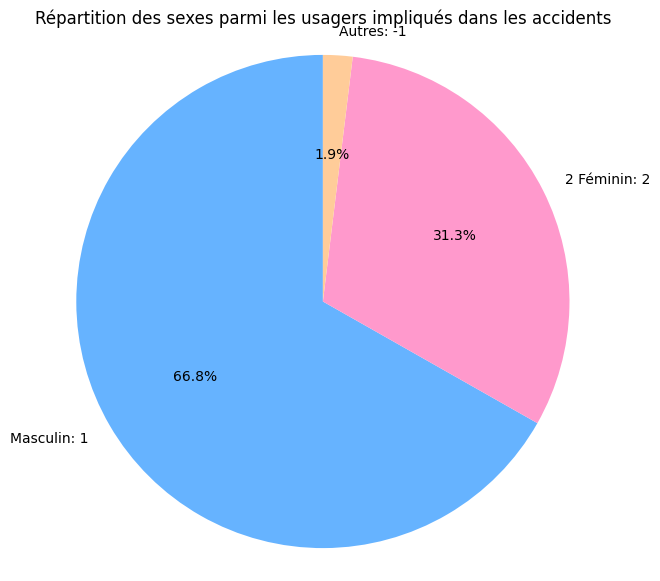

In [10]:
df_usagers['sexe_label'] = df_usagers['sexe'].replace({
    1: 'Masculin: 1', 
    2: '2 Féminin: 2', 
    -1: 'Autres: -1'
})

# Compter la répartition des sexes après remplacement
sexe_counts = df_usagers['sexe_label'].value_counts()

colors = ['#66b3ff', '#ff99cc', '#ffcc99']  # Masculin, Féminin, Autres

# Tracer un diagramme circulaire
plt.figure(figsize=(7, 7))
plt.pie(sexe_counts, labels=sexe_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Répartition des sexes parmi les usagers impliqués dans les accidents")
plt.axis('equal') 
plt.show()
#La majorité des usagers impliqués dans les accidents sont de sexe masculin, représentant 68,8% du total. 
# Cela suggère que, dans cette population, les hommes sont nettement plus nombreux que les femmes à être impliqués dans des accidents.
# Les femmes représentent 31,3% des usagers impliqués et la catégorie "autres" représente 1,9% des cas, ce qui pourrait inclure des 
# personnes dont le sexe n'est pas précisé ou qui ne s'identifient pas selon les catégories traditionnelles de sexe. 
# Cette proportion est relativement faible, mais elle mérite d'être mentionnée.

Catégorie d'usagers (catu) : Identification des catégories les plus exposées (conducteurs, passagers, piétons).

Statistiques des catégories d'usagers :
            Fréquence  Proportion
catu                             
Conducteur      93462    0.743006
Passager        22806    0.181304
Piéton           9521    0.075690


/tmp/ipykernel_18054/2983193703.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=catu_counts.index, y=catu_counts.values, palette='Blues_d')


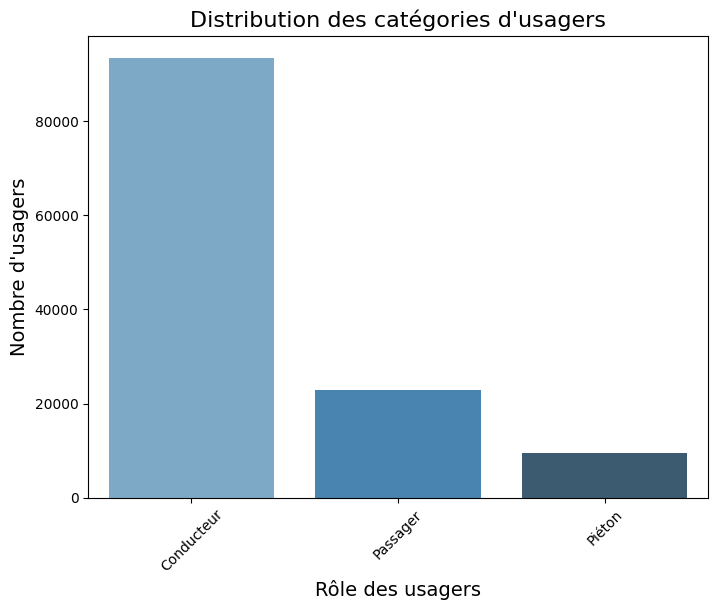

In [11]:
# Statistiques descriptives 
catu_counts = df_usagers['catu'].value_counts()
catu_proportions = df_usagers['catu'].value_counts(normalize=True)

catu_labels = {1: 'Conducteur', 2: 'Passager', 3: 'Piéton'}
catu_counts = catu_counts.rename(index=catu_labels)
catu_proportions = catu_proportions.rename(index=catu_labels)

catu_summary = pd.DataFrame({
    'Fréquence': catu_counts,
    'Proportion': catu_proportions
})

print("Statistiques des catégories d'usagers :")
print(catu_summary)

# Graphique : diagramme à barres
plt.figure(figsize=(8, 6))
sns.barplot(x=catu_counts.index, y=catu_counts.values, palette='Blues_d')

plt.title('Distribution des catégories d\'usagers', fontsize=16)
plt.xlabel('Rôle des usagers', fontsize=14)
plt.ylabel('Nombre d\'usagers', fontsize=14)
plt.xticks(rotation=45)
plt.show()
# On observe que la majorité des personnes impliquées dans des accidents sont des conducteurs(soit 74,3% des usagers), 
# ensuite vient les passagers (18,1%) et enfin les piétons (7.6%). 

Répartition selon la gravité (grav) : Observation de la distribution des niveaux de gravité des accidents (1: indemne, 2: Tué, 3: blessé hospitalisé plus de 24h, 4: Blessé léger).

Nombre d'observations par niveau de gravité:
grav
-1      118
 1    53399
 2     3398
 3    19271
 4    49603
Name: count, dtype: int64

Pourcentage d'observations par niveau de gravité:
grav
-1     0.093808
 1    42.451248
 2     2.701349
 3    15.320100
 4    39.433496
Name: proportion, dtype: float64


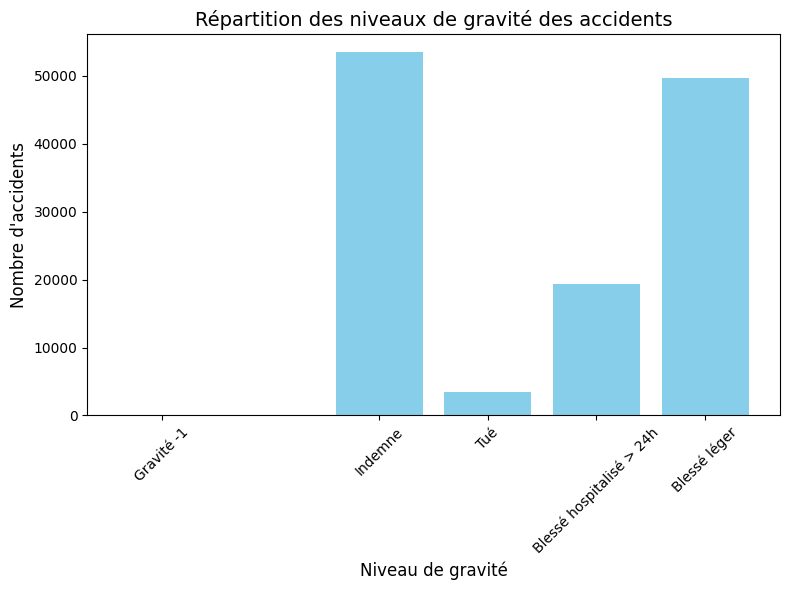

In [12]:
# Statistiques descriptives 
grav_stats = df_usagers['grav'].value_counts().sort_index()
grav_percentage = df_usagers['grav'].value_counts(normalize=True).sort_index() * 100

print("Nombre d'observations par niveau de gravité:")
print(grav_stats)

print("\nPourcentage d'observations par niveau de gravité:")
print(grav_percentage)

grav_labels = {
    1: 'Indemne', 
    2: 'Tué', 
    3: 'Blessé hospitalisé > 24h', 
    4: 'Blessé léger'
}

plt.figure(figsize=(8, 6))
plt.bar(grav_stats.index, grav_stats.values, color='skyblue')

plt.title('Répartition des niveaux de gravité des accidents', fontsize=14)
plt.xlabel('Niveau de gravité', fontsize=12)
plt.ylabel('Nombre d\'accidents', fontsize=12)
plt.xticks(grav_stats.index, [grav_labels.get(i, f"Gravité {i}") for i in grav_stats.index], rotation=45)

plt.tight_layout()
plt.show()
#Les résultats montrent que la majorité des usagers impliqués dans les accidents (42,45 %) sont indemnes, ce qui indique que 
# les accidents sont souvent de faible gravité. Cependant, une proportion importante (39,43 %) subit des blessures légères, 
# tandis que 15,32 % sont gravement blessés et nécessitent une hospitalisation de plus de 24 heures. 
# Les accidents mortels représentent 2,7 % des cas, ce qui reste préoccupant. Il est également important de noter la présence 
# de valeurs -1 dans la variable de gravité, représentant environ 0,09 % des observations.

Analyse de la gravité en fonction du sexe ou de la catégorie d'usager.


Répartition de la gravité selon le sexe (en pourcentage) :
sexe         -1          1          2
grav                                 
-1     4.771699   0.002381   0.000000
 1    95.228301  43.423042  37.115262
 2     0.000000   3.148322   1.913839
 3     0.000000  16.099889  14.601601
 4     0.000000  37.326366  46.369297


<Figure size 1000x600 with 0 Axes>

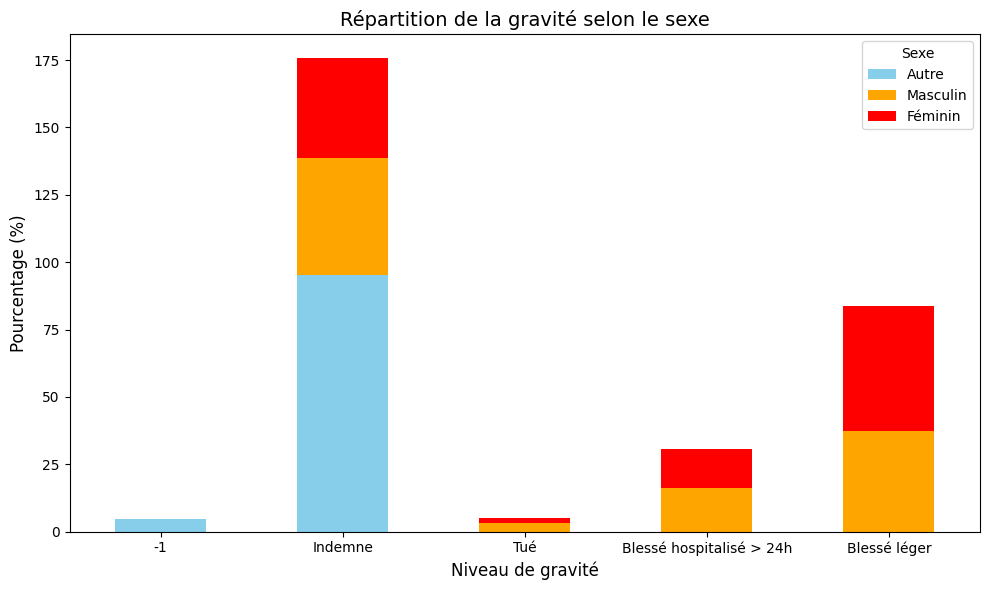


Répartition de la gravité selon la catégorie d’usager (en pourcentage) :
catu          1          2          3
grav                                 
-1     0.123045   0.000000   0.031509
 1    47.475980  38.266246   3.150930
 2     2.610687   2.122249   4.978469
 3    14.237872  14.768043  27.266043
 4    35.552417  44.843462  64.573049


<Figure size 1200x800 with 0 Axes>

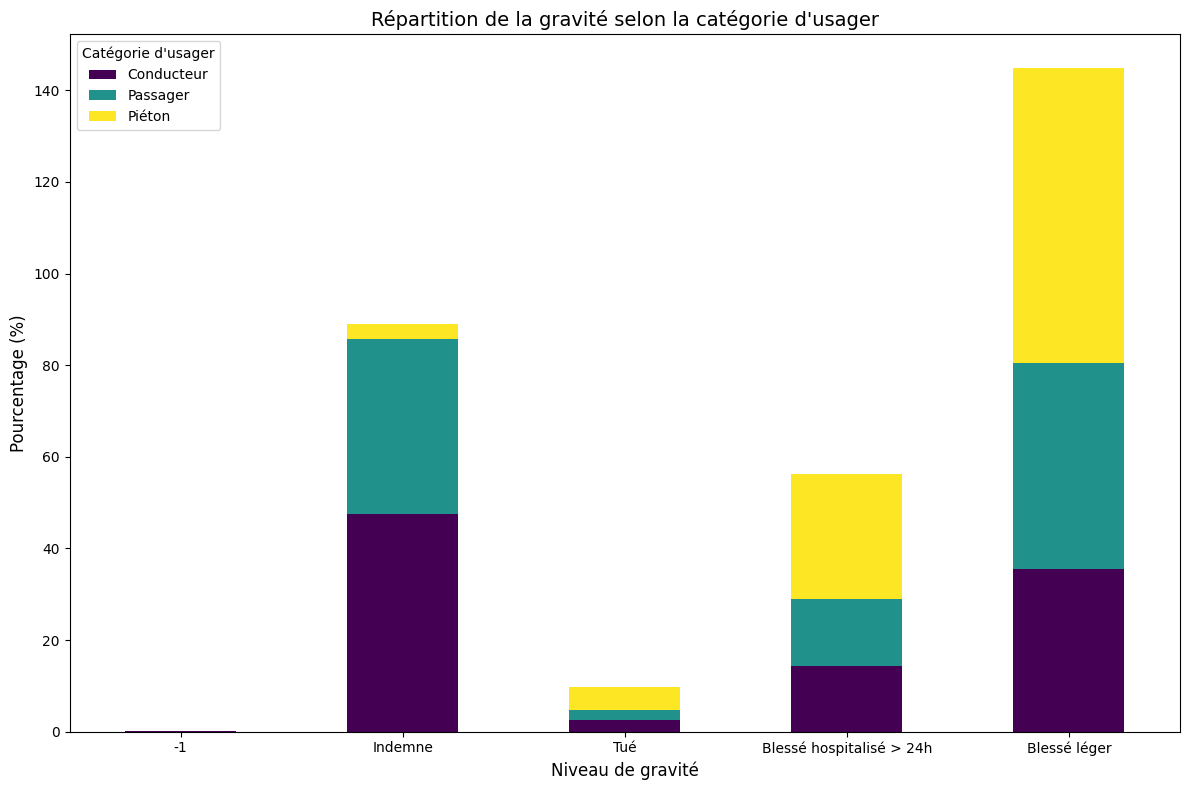

In [13]:
# Dictionnaires pour les libellés
sexe_labels = {1: 'Masculin', 2: 'Féminin', -1: 'Autre'}
catu_labels = {1: 'Conducteur', 2: 'Passager', 3: 'Piéton'}
grav_labels = {1: 'Indemne', 2: 'Tué', 3: 'Blessé hospitalisé > 24h', 4: 'Blessé léger'}

# 1. Croisement entre gravité et sexe
grav_sexe = pd.crosstab(df_usagers['grav'], df_usagers['sexe'], normalize='columns') * 100

print("\nRépartition de la gravité selon le sexe (en pourcentage) :")
print(grav_sexe)

# Visualisation de la gravité en fonction du sexe
plt.figure(figsize=(10, 6))
grav_sexe.index = [grav_labels.get(i, str(i)) for i in grav_sexe.index]  # Remplacer les indices par les libellés
grav_sexe.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'orange', 'red', 'green'])
plt.title('Répartition de la gravité selon le sexe', fontsize=14)
plt.xlabel('Niveau de gravité', fontsize=12)
plt.ylabel('Pourcentage (%)', fontsize=12)
plt.legend(title='Sexe', labels=[sexe_labels.get(x, str(x)) for x in grav_sexe.columns])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Croisement entre gravité et catégorie d’usager
grav_usager = pd.crosstab(df_usagers['grav'], df_usagers['catu'], normalize='columns') * 100

print("\nRépartition de la gravité selon la catégorie d’usager (en pourcentage) :")
print(grav_usager)

# Visualisation de la gravité en fonction de la catégorie d’usager
plt.figure(figsize=(12, 8))
grav_usager.index = [grav_labels.get(i, str(i)) for i in grav_usager.index]  # Remplacer les indices par les libellés
grav_usager.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Répartition de la gravité selon la catégorie d\'usager', fontsize=14)
plt.xlabel('Niveau de gravité', fontsize=12)
plt.ylabel('Pourcentage (%)', fontsize=12)
plt.legend(title='Catégorie d\'usager', labels=[catu_labels.get(x, str(x)) for x in grav_usager.columns])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
 
#La répartition de la gravité selon le sexe met en évidence une surreprésentation des hommes dans toutes les catégories de gravité.
#  Les hommes représentent la majorité des personnes indemnes, des blessés légers, des blessés graves (hospitalisation > 24h) et des tués.
#  Les femmes, bien qu’impliquées dans les accidents, présentent des proportions plus faibles dans toutes les catégories de gravité. 
# Cette différence dans la répartition pourrait être liée à des variations dans les types d'usagers ou les comportements sur la route selon le sexe.

#Concernant la catégorie d’usager, les conducteurs sont les plus représentés dans toutes les catégories de gravité,
#  qu’il s’agisse des personnes indemnes, blessées légèrement, blessées gravement ou tuées. Les piétons, bien que 
# proportionnellement moins nombreux que les conducteurs, affichent une part plus importante dans les catégories graves, 
# notamment les hospitalisations et les décès. Les passagers, quant à eux, se retrouvent principalement dans les catégories de blessures légères et d’indemnes,
#  avec une proportion plus faible dans les cas graves ou mortels. Ces différences illustrent des niveaux d’exposition distincts selon la catégorie d’usager.


analyse des équipements de sécurité (secu1, secu2, secu3)


Répartition des dispositifs de sécurité (secu1) :
secu1_label
Ceinture              65.633149
Casque                19.793896
Non déterminable      13.920112
Dispositif enfants     0.652842
Name: proportion, dtype: float64


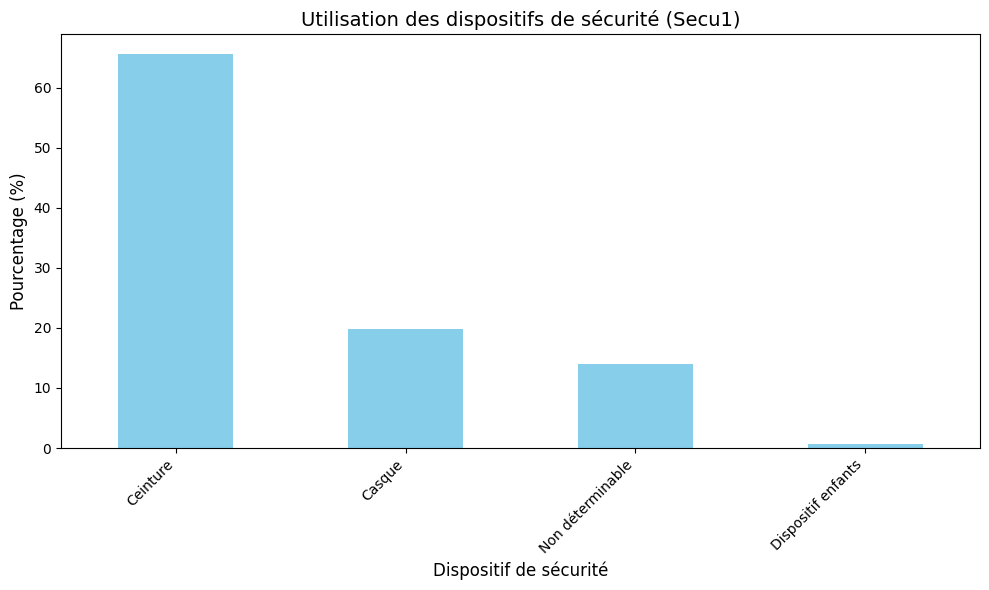


Répartition des équipements de sécurité (secu2) :
secu2_label
Aucun équipement                     74.623846
Gants (2/3 RM)                       19.880968
Gilet réfléchissant                   2.549485
Airbag personnel (2/3 RM)             1.929250
Autres équipements                    0.780728
Airbag personnel + Gants (2/3 RM)     0.235723
Name: proportion, dtype: float64


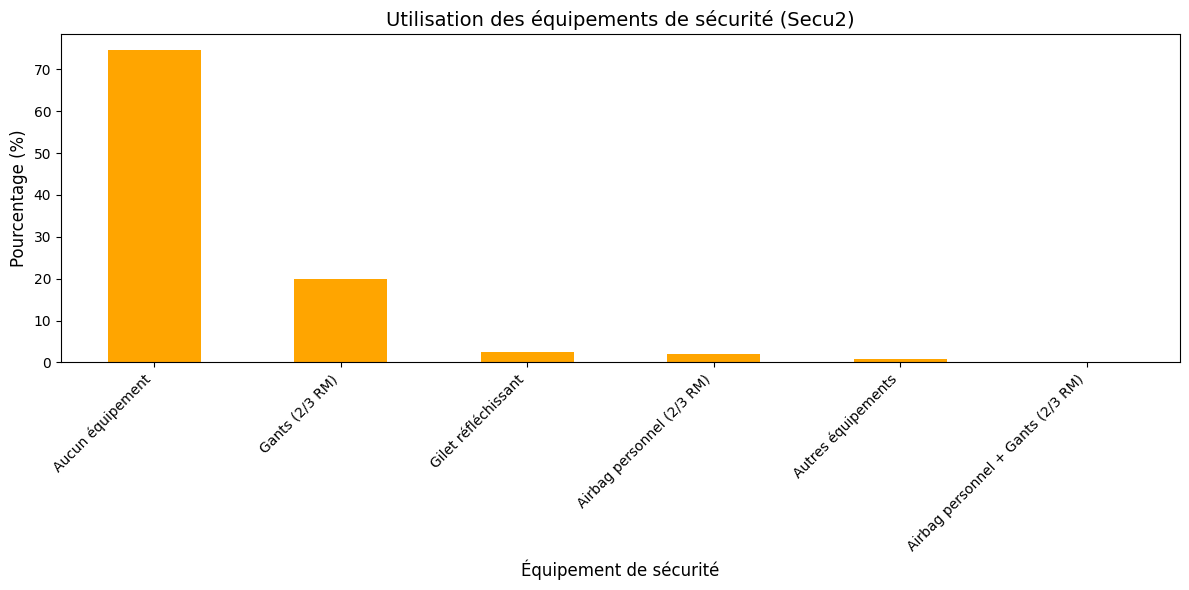


Impact des dispositifs de sécurité (Secu1) sur les accidents graves (en %) :
secu1_label
Casque                65.382519
Ceinture              89.387297
Dispositif enfants    90.909091
Non déterminable      83.320413
Name: accident_grave, dtype: float64


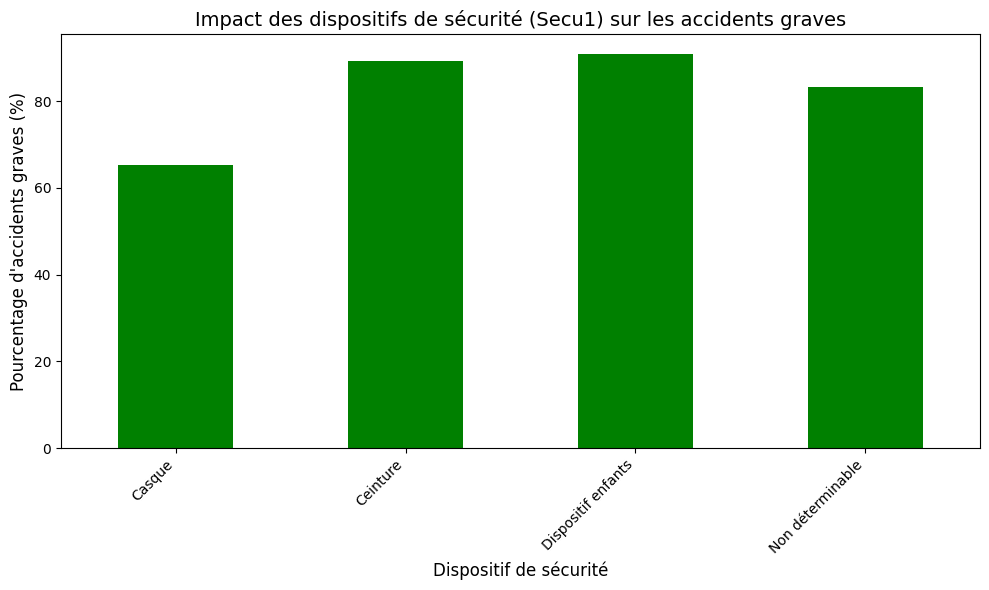


Impact des équipements de sécurité (Secu2) sur les accidents graves (en %) :
secu2_label
Airbag personnel (2/3 RM)            82.062392
Airbag personnel + Gants (2/3 RM)    73.049645
Aucun équipement                     93.388893
Autres équipements                   55.460385
Gants (2/3 RM)                       64.026236
Gilet réfléchissant                  95.016393
Name: accident_grave, dtype: float64


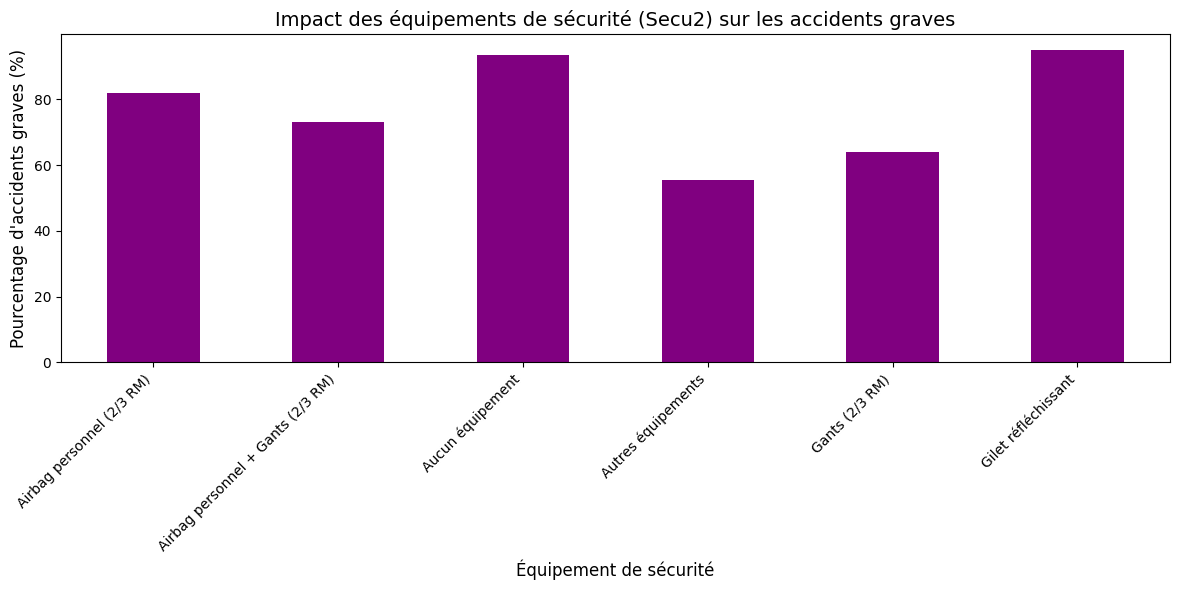

In [ ]:
secu1_labels = {
    1: 'Ceinture',
    2: 'Casque',
    3: 'Dispositif enfants',
    8: 'Non déterminable'
}

secu2_labels = {
    0: 'Aucun équipement',
    4: 'Gilet réfléchissant',
    5: 'Airbag personnel (2/3 RM)',
    6: 'Gants (2/3 RM)',
    7: 'Airbag personnel + Gants (2/3 RM)',
    9: 'Autres équipements'
}

# Mapping des libellés sur le DataFrame
df_usagers['secu1_label'] = df_usagers['secu1'].map(secu1_labels)
df_usagers['secu2_label'] = df_usagers['secu2'].map(secu2_labels)

df_usagers['accident_grave'] = df_usagers['grav'].apply(lambda x: 1 if x in [1, 4] else 0)

# 1. Étude de l'utilisation des dispositifs de sécurité
secu1_usage = df_usagers['secu1_label'].value_counts(normalize=True) * 100
secu2_usage = df_usagers['secu2_label'].value_counts(normalize=True) * 100

print("\nRépartition des dispositifs de sécurité (secu1) :")
print(secu1_usage)

# Visualisation de l'utilisation des dispositifs de sécurité (secu1)
plt.figure(figsize=(10, 6))
secu1_usage.plot(kind='bar', color='skyblue')
plt.title('Utilisation des dispositifs de sécurité (Secu1)', fontsize=14)
plt.xlabel('Dispositif de sécurité', fontsize=12)
plt.ylabel('Pourcentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nRépartition des équipements de sécurité (secu2) :")
print(secu2_usage)

# Visualisation de l'utilisation des équipements de sécurité (secu2)
plt.figure(figsize=(12, 6))
secu2_usage.plot(kind='bar', color='orange')
plt.title('Utilisation des équipements de sécurité (Secu2)', fontsize=14)
plt.xlabel('Équipement de sécurité', fontsize=12)
plt.ylabel('Pourcentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Comparaison des taux de blessures graves ou de décès
impact_secu1 = df_usagers.groupby('secu1_label')['accident_grave'].mean() * 100
impact_secu2 = df_usagers.groupby('secu2_label')['accident_grave'].mean() * 100

print("\nImpact des dispositifs de sécurité (Secu1) sur les accidents graves (en %) :")
print(impact_secu1)

# Visualisation de l'impact des dispositifs de sécurité sur les accidents graves (secu1)
plt.figure(figsize=(10, 6))
impact_secu1.plot(kind='bar', color='green')
plt.title('Impact des dispositifs de sécurité (Secu1) sur les accidents graves', fontsize=14)
plt.xlabel('Dispositif de sécurité', fontsize=12)
plt.ylabel('Pourcentage d\'accidents graves (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nImpact des équipements de sécurité (Secu2) sur les accidents graves (en %) :")
print(impact_secu2)

# Visualisation de l'impact des équipements de sécurité sur les accidents graves (secu2)
plt.figure(figsize=(12, 6))
impact_secu2.plot(kind='bar', color='purple')
plt.title('Impact des équipements de sécurité (Secu2) sur les accidents graves', fontsize=14)
plt.xlabel('Équipement de sécurité', fontsize=12)
plt.ylabel('Pourcentage d\'accidents graves (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
## Répartition des dispositifs de sécurité (Secu1 et Secu2)

#En examinant la répartition des dispositifs de sécurité secu1, on constate que la ceinture 
# de sécurité est l'équipement le plus fréquemment utilisé, avec 65,63 % des usagers. 
# Le casque suit avec 19,79 %, tandis que les dispositifs pour enfants représentent 
# une part marginale, à 0,65 %. Une proportion non négligeable (13,92 %) des équipements n'est pas déterminée,
#  ce qui pourrait indiquer un manque de données ou d'informations sur certains usagers.

#Pour secu2, une majorité (74,62 %) des usagers impliqués dans les accidents ne portaient aucun 
# équipement spécifique. Parmi ceux qui portaient des équipements, les gants (2/3 RM) sont 
# les plus courants (19,88 %), suivis des gilets réfléchissants (2,54 %) et
# des airbags personnels (2/3 RM) (1,93 %). Les autres équipements et 
# les combinaisons airbag personnel + gants (2/3 RM) représentent des proportions plus faibles (0,78 % et 0,23 %, respectivement).


## Impact des dispositifs de sécurité sur la gravité des accidents

#L'analyse montre une relation entre l'utilisation des dispositifs de sécurité (secu1) 
# et la gravité des accidents. Les usagers portant des dispositifs pour enfants enregistrent
#  le pourcentage le plus élevé d'accidents graves (blessures graves ou décès) à 90,91 %, suivi 
# par ceux portant la ceinture de sécurité (89,39 %). Les usagers avec des équipements non déterminables 
# enregistrent également un impact élevé (83,32 %), tandis que ceux portant un casque présentent un pourcentage moindre (65,38 %).

#En ce qui concerne les équipements spécifiques (secu2), les usagers ne portant aucun équipement présentent 
#le pourcentage d'accidents graves le plus élevé (93,39 %), suivi par ceux portant des gilets réfléchissants (95,02 %). 
# À l'inverse, les usagers portant des gants (2/3 RM) et des airbags personnels + gants enregistrent des impacts plus modérés, à 64,03 % et 73,05 %, respectivement. 
#Enfin, ceux portant d'autres équipements affichent le pourcentage le plus faible d'accidents graves (55,46 %), indiquant une meilleure protection potentielle.

Prochainement 
- Dans la partie analyse des trajets (trajet), nous:
       - Examinerons les types de trajets (domicile-travail, domicile-école, etc.) les plus liés aux accidents.
       - Identifierons si certains trajets présentent un risque plus élevé.
- Dans la partie localisation et activité des usagers (locp: localisation du piéton au moment de l'accident, actp: Action du piéton, etatp: Etat du piéton), nous ferons une analyse de cette partie.
Nous observerons les corrélations entre l'état ou l'activité d’un usager (ex. marchant, traversant) et les risques.

Nous créerons des tableaux croisés dynamiques pour explorer les relations entre variables.

In [9]:
# Base des véhicules 
df_vehicules = pd.read_csv(r"/home/onyxia/Projet-Python-pour-la-Data-Science/data/vehicules-2023.csv", sep = ';')
df_vehicules.head()

,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc
0,202300000001,155 680 557,A01,1,30,0,0,5,1,1,NaN
1,202300000002,155 680 556,A01,2,7,0,1,1,1,1,NaN
2,202300000003,155 680 554,B01,1,2,0,2,1,16,1,NaN
3,202300000003,155 680 555,A01,2,7,0,2,2,15,1,NaN
4,202300000004,155 680 551,B01,1,7,0,2,9,2,4,NaN


In [10]:
# Base des lieux 
df_lieux = pd.read_csv(r"/home/onyxia/Projet-Python-pour-la-Data-Science/data/lieux-2023.csv", sep = ';')
df_lieux.head()

C:\Users\lisaw\AppData\Local\Temp\ipykernel_24512\2020527371.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lieux = pd.read_csv(r"/home/onyxia/Projet-Python-pour-la-Data-Science/data/lieux-2023.csv", sep = ';')


,Num_Acc,catr,voie,v1,v2,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,202300000001,4,RUE DE RIVOLI,0,NaN,1,2,0,1,-1,-1,1,NaN,-1,2,0,1,30
1,202300000001,4,RUE SAINT FLORENTIN,0,NaN,1,1,0,1,-1,-1,1,NaN,-1,2,0,1,30
2,202300000002,3,120,0,NaN,2,3,2,1,-1,-1,1,NaN,-1,2,0,1,50
3,202300000003,3,5,0,NaN,2,4,0,1,1,0,1,NaN,-1,2,5,1,50
4,202300000003,3,87,0,NaN,2,4,0,1,1,0,1,NaN,-1,2,5,1,50


In [11]:
df_caract = pd.read_csv(r"/home/onyxia/Projet-Python-pour-la-Data-Science/data/caract-2023.csv", sep = ';')
df_caract.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long
0,202300000001,7,5,2023,06:00,1,75,75101,2,4,2,7,RUE DE RIVOLI,"48,86638600","2,32347100"
1,202300000002,7,5,2023,05:30,5,94,94080,2,1,3,6,Avenue de Paris,"48,84547782","2,42868146"
2,202300000003,7,5,2023,20:50,1,94,94022,2,3,2,1,Avenue du Général Leclerc,"48,76240000","2,40655000"
3,202300000004,6,5,2023,23:57,5,94,94078,2,1,3,5,Rue de Paris,"48,73248432","2,44687575"
4,202300000005,7,5,2023,00:50,5,94,94068,2,2,3,3,56bis Avenue Raspail,"48,78581000","2,49217000"


In [13]:
df_caract.shape

(54822, 15)

## Fusion des bases de données

In [33]:

df_merge = df_usagers.merge(df_vehicules, on=["Num_Acc","id_vehicule"], how="inner") 
df_merge = df_merge.merge(df_lieux, on="Num_Acc", how="inner")
df_merge = df_merge.merge(df_caract, on="Num_Acc", how="inner")
df_merge.shape

(163683, 56)

In [ ]:
# ajout du libellé des départements

df_code_dep=df_dep[["DEP","LIBELLE"]]
#df_code_com=df_com[["COM","LIBELLE"]]
df_merge=pd.merge(left=df_merge, right=df_code_dep,left_on="dep", right_on="DEP", how="left")
#database=pd.merge(left=df_merge, right=df_code_com,left_on="com", right_on="COM", how="left")
database=df_merge.drop(["DEP"], axis=1)
database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163683 entries, 0 to 163682
Data columns (total 57 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      163683 non-null  int64  
 1   id_usager    163683 non-null  object 
 2   id_vehicule  163683 non-null  object 
 3   num_veh_x    163683 non-null  object 
 4   place        163683 non-null  int64  
 5   catu         163683 non-null  int64  
 6   grav         163683 non-null  int64  
 7   sexe         163683 non-null  int64  
 8   an_nais      160171 non-null  float64
 9   trajet       163683 non-null  int64  
 10  secu1        163683 non-null  int64  
 11  secu2        163683 non-null  int64  
 12  secu3        163683 non-null  int64  
 13  locp         163683 non-null  int64  
 14  actp         163683 non-null  object 
 15  etatp        163683 non-null  int64  
 16  num_veh_y    163683 non-null  object 
 17  senc         163683 non-null  int64  
 18  catv         163683 non-

## Nettoyage de la base

In [ ]:
# gerer les valeurs manquantes et les recodages. se servir de la documentation des variables

(20, 2)

## Description univariées

In [56]:
print(f"la base usagers a {df_usagers.shape[0]} observations et {df_usagers.shape[1]} variables.")

la base usagers a 125789 observations et 16 variables.


Text(0, 0.5, 'percentage(%)')

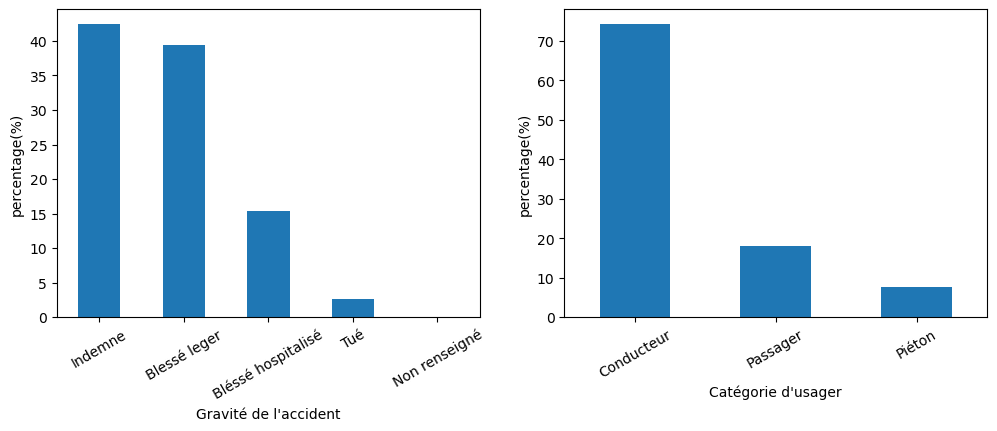

In [55]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
grav_dict={-1:"Non renseigné",1:'Indemne',2:"Tué",3:'Bléssé hospitalisé',4:'Blessé leger'}
grav_nv=df_usagers['grav'].replace(grav_dict)
grav_prct=(grav_nv.value_counts()/df_usagers.shape[0])*100
grav_prct.plot(kind="bar")
plt.xticks(rotation=30)
plt.xlabel("Gravité de l'accident")
plt.ylabel("percentage(%)")

plt.subplot(1,2,2)
catu_dict={1:"Conducteur",2:"Passager",3:"Piéton"}
catu_nv=df_usagers['catu'].replace(catu_dict)
catu_prct=(catu_nv.value_counts()/df_usagers.shape[0])*100
catu_prct.plot(kind="bar")
plt.xticks(rotation=30)
plt.xlabel("Catégorie d'usager")
plt.ylabel("percentage(%)")


Text(0, 0.5, 'percentage(%)')

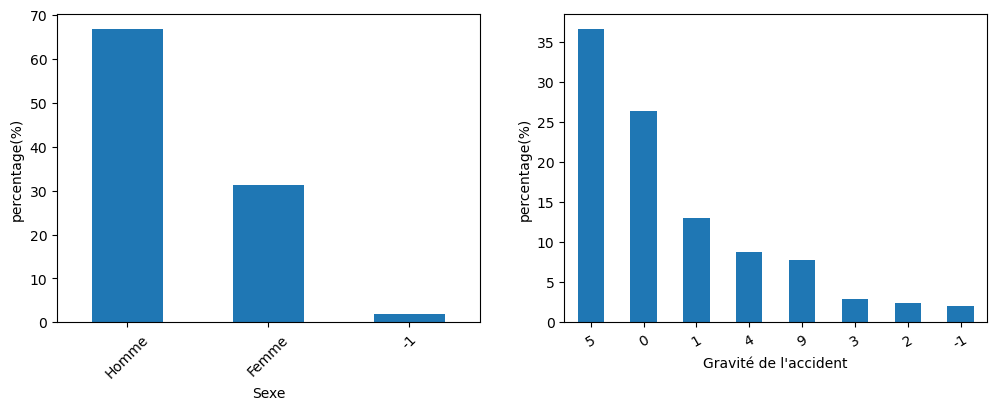

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
sexe_dict={1:"Homme",2:"Femme"}
sexe_nv=df_usagers['sexe'].replace(sexe_dict)
sexe_prct=(sexe_nv.value_counts()/df_usagers.shape[0])*100
sexe_prct.plot(kind="bar")
plt.xticks(rotation=45)
plt.xlabel("Sexe")
plt.ylabel("percentage(%)")


plt.subplot(1,2,2)
#grav_dict={-1:"Non renseigné",1:'Indemne',2:"Tué",3:'Bléssé hospitalisé',4:'Blessé leger'}
#grav_nv=df_usagers['grav'].replace(grav_dict)
grav_prct=(df_usagers['trajet'].value_counts()/df_usagers.shape[0])*100
grav_prct.plot(kind="bar")
plt.xticks(rotation=30)
plt.xlabel("Gravité de l'accident")
plt.ylabel("percentage(%)")


In [ ]:
#cration carte
import geopandas as gpd

In [ ]:
accidents_par_departement = df_caract.groupby('dep').size().reset_index(name='nombre_accidents')
accidents_par_departement.head()

In [ ]:
france_map = gpd.read_file("https://france-geojson.gregoiredavid.fr/repo/departements.geojson")
france_map = france_map.merge(accidents_par_departement, left_on="code", right_on="dep")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
france_map.plot(column="nombre_accidents", cmap="OrRd", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)

plt.title("Nombre d'accidents de la route par département")
plt.axis("off")
plt.show()

In [ ]:
dep_IDF = ["75", "77", "78", "91", "92", "93", "94", "95"]
accidents_idf = df_caract[df_caract['dep'].isin(dep_IDF)]

# Remplacer les virgules par des points et convertir en float
accidents_idf['lat'] = accidents_idf['lat'].str.replace(',', '.').astype(float)
accidents_idf['long'] = accidents_idf['long'].str.replace(',', '.').astype(float)

accidents_idf.head()

In [ ]:
import folium
from folium.plugins import HeatMap

accidents_coords = accidents_idf[['lat', 'long']].dropna()

# Initialiser la carte centrée sur l'Île-de-France
map_idf = folium.Map(location=[48.8566, 2.3522], zoom_start=10)

# Ajouter la carte de densité
HeatMap(
    data=accidents_coords.values,
    radius=10,               
    blur=15,                 
    max_zoom=10,             
    min_opacity=0.2,         
    gradient={               
        0.2: 'blue',
        0.4: 'lime',
        0.6: 'yellow',
        0.8: 'orange',
        1.0: 'red'
    }
).add_to(map_idf)

# Afficher la carte
map_idf